In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# Importing the Quarterly data from OECD on Danish GDP 1990-2023
gdp = pd.read_csv(".//QGDP.csv", sep=';', header=None)
cons = pd.read_csv(".//Consumer.csv", sep=';')
indu = pd.read_csv(".//Industry.csv", sep=';')

In [2]:
#Selecting the relevant columns
gdp = gdp[[2, 3]]

## There is 13 questions the consumers have answered in the survey:
## - COF	Confidence Indicator (Q1 + Q2 + Q4 + Q9) / 4 (CONS.DK.TOT.COF.B.M)
## - 1	Financial situation over last 12 months (CONS.DK.TOT.1.B.M)
## - 2	Financial situation over next 12 months (CONS.DK.TOT.2.B.M)
## - 3	General economic situation over last 12 months (CONS.DK.TOT.3.B.M)
## - 4	General economic situation over next 12 months (CONS.DK.TOT.4.B.M)
## - 5	Price trends over last 12 months (CONS.DK.TOT.5.B.M)
## - 6	Price trends over next 12 months (CONS.DK.TOT.6.B.M)
## - 7	Unemployment expectations over next 12 months (CONS.DK.TOT.7.B.M)
## - 8	Major purchases at present (CONS.DK.TOT.8.B.M)
## - 9	Major purchases over next 12 months (CONS.DK.TOT.9.B.M)
## - 10	Savings at present (CONS.DK.TOT.10.B.M)
## - 11	Savings over next 12 months (CONS.DK.TOT.11.B.M)
## - 12	Statement on financial situation of household (CONS.DK.TOT.12.B.M)

##Selecting COF
cons = cons[['Time', 'CONS.DK.TOT.COF.B.M']]

##There is 8 relevant questions in the industry survey:
## - COF	Confidence Indicator (Q2 - Q4 + Q5) / 3 (INDU.DK.TOT.COF.B.M)
## - 1	Production trend observed in recent months (INDU.DK.TOT.1.B.M)
## - 2	Assessment of order-book levels (INDU.DK.TOT.2.B.M)
## - 3	Assessment of export order-book levels (INDU.DK.TOT.3.B.M)
## - 4	Assessment of stocks of finished products (INDU.DK.TOT.4.B.M)
## - 5	Production expectations for the months ahead (INDU.DK.TOT.5.B.M)
## - 6	Selling price expectations for the months ahead (INDU.DK.TOT.6.B.M)
## - 7	Employment expectations for the months ahead (INDU.DK.TOT.7.B.M)

## Selecting COF
indu = indu[['Time', 'INDU.DK.TOT.COF.B.M']]

In [3]:
#Renaming the columns
gdp = gdp.rename(columns={2: 'Time', 3: 'Value'})
cons = cons.rename(columns={'CONS.DK.TOT.COF.B.M': 'Value'})
indu = indu.rename(columns={'INDU.DK.TOT.COF.B.M': 'Value'})

#Converting the Time column to datetime
cons['Time'] = pd.to_datetime(cons['Time'], format='%d-%m-%Y')
indu['Time'] = pd.to_datetime(indu['Time'], format='%d-%m-%Y')
gdp['Time'] = pd.to_datetime(gdp['Time'])

# Converting the Value column to float64 in indu and cons
indu['Value'] = pd.to_numeric(indu['Value'], errors='coerce').astype('float64')

cons['Value'] = pd.to_numeric(cons['Value'], errors='coerce').astype('float64')


#Checking the data types
print("Data types in 'indu' dataframe:")
print(indu.dtypes)

print("\nData types in 'cons' dataframe:")
print(cons.dtypes)

print("\nData types in 'gdp' dataframe:")
print(gdp.dtypes)

Data types in 'indu' dataframe:
Time     datetime64[ns]
Value           float64
dtype: object

Data types in 'cons' dataframe:
Time     datetime64[ns]
Value           float64
dtype: object

Data types in 'gdp' dataframe:
Time     datetime64[ns]
Value           float64
dtype: object


In [4]:
# Resample indu and cons to quarterly frequency, using the mean value per quarter
indu_quarterly = indu.resample('Q', on='Time').mean()
cons_quarterly = cons.resample('Q', on='Time').mean()

# Adjust the datetime to the first day of the quarter
indu_quarterly['Time'] = indu_quarterly.index.to_period('Q').asfreq('Q-DEC', 'start').to_timestamp()
cons_quarterly['Time'] = cons_quarterly.index.to_period('Q').asfreq('Q-DEC', 'start').to_timestamp()

#Resetting the index of the new dataframes
indu_quarterly.reset_index(drop=True, inplace=True)
cons_quarterly.reset_index(drop=True, inplace=True)

#Checking the data types
print(indu_quarterly.dtypes)
print(cons_quarterly.dtypes)

Value           float64
Time     datetime64[ns]
dtype: object
Value           float64
Time     datetime64[ns]
dtype: object


In [5]:
#Filtering the data to only include the years 1990-2023, as this is the limitation in gdp dataset
indu_quarterly = indu_quarterly[(indu_quarterly['Time'] >= '1990-01-01') & (indu_quarterly['Time'] < '2024-01-01')]
cons_quarterly = cons_quarterly[(cons_quarterly['Time'] >= '1990-01-01') & (cons_quarterly['Time'] < '2024-01-01')]

In [6]:
#Cleanup
cons = cons_quarterly
indu = indu_quarterly

cons.reset_index(drop=True, inplace=True)
indu.reset_index(drop=True, inplace=True)

del cons_quarterly, indu_quarterly

In [7]:
#Combine the training data by matching the time
data = pd.merge(indu, cons, on='Time', how='inner')
data = pd.merge(data, gdp, on='Time', how='inner')


#Renaming the columns
data.columns = ['indu','Time', 'cons', 'gdp']

In [8]:
# Installing Python 3.10.12
%pip install python==3.10.12

# Installing accelerate package for faster computation
%pip install accelerate

# Installing keras package for deep learning
%pip install keras

# Installing tensorflow package for deep learning
%pip install tensorflow

# Installing torch package for deep learning
%pip install torch

# Installing transformers package for deep learning
%pip install transformers

# Installing xgboost package for gradient boosting
%pip install xgboost

# Installing langchain package for natural language processing
%pip install langchain

# Installing pmdarima package for time series analysis
%pip install pmdarima

# Installing statsmodels package for time series analysis
%pip install statsmodels

# Installing pandas package for data manipulation
%pip install pandas

# Installing numpy package for numerical computation
%pip install numpy

# Installing matplotlib package for data visualization
%pip install matplotlib

# Installing scikit-learn package for machine learning
%pip install scikit-learn

ERROR: Could not find a version that satisfies the requirement python==3.10.12 (from versions: none)
ERROR: No matching distribution found for python==3.10.12
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 5.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux

In [9]:
from langchain.chains.combine_documents.stuff import StuffDocumentsChain
from langchain.chains.llm import LLMChain
from langchain.prompts import PromptTemplate
from langchain.chains.summarize import load_summarize_chain
from langchain.text_splitter import CharacterTextSplitter
from langchain.chains.summarize import load_summarize_chain
from langchain.chains.combine_documents.stuff import StuffDocumentsChain
from langchain.chains.llm import LLMChain
from langchain.prompts import PromptTemplate
from langchain.chains.summarize import load_summarize_chain

In [10]:
import torch

from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig, pipeline
import os
from google.colab import userdata

# Set the Hugging Face API token as an environment variable
os.environ["HF_TOKEN"] = userdata.get("huggingface_key")

#Set the device to use
device = torch.device("cuda")


MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.2"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME, torchscript=True, torch_dtype=torch.float16, trust_remote_code=True, device_map="auto"
)

# Create a configuration for text generation based on the specified model name
generation_config = GenerationConfig.from_pretrained(MODEL_NAME)

# Set the maximum number of new tokens in the generated text to 1024.
# This limits the length of the generated output to 1024 tokens.
generation_config.max_new_tokens = 1024

# Set the temperature for text generation. Lower values (e.g., 0.0001) make output more deterministic, following likely predictions.
# Higher values make the output more random.
generation_config.temperature = 0.01

# Set the top-p sampling value. A value of 0.95 means focusing on the most likely words that make up 95% of the probability distribution.
generation_config.top_p = 0.95

# Enable text sampling. When set to True, the model randomly selects words based on their probabilities, introducing randomness.
generation_config.do_sample = True

# Set the repetition penalty. A value of 1.15 discourages the model from repeating the same words or phrases too frequently in the output.
generation_config.repetition_penalty = 1.15


# Create a text generation pipeline using the initialized model, tokenizer, and generation configuration
text_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    generation_config=generation_config
)


tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

In [12]:
#Creating 16 prompts for the model to generate text from based on the last 16 rows in the data

prompts = []

def get_quarter(date):
    return pd.Timestamp(date).to_period('Q')

for i in range(16):
    prompt = ("Your task is to provide a GDP forecast for Denmark in the quarter " + str(get_quarter(data['Time'].iloc[-16+i])) + " based solely on the following historical data from previous quarters:"
              + str(data.iloc[-20-i]['Time'].date()) + ": GDP; " + str(data.iloc[-20-i]['gdp']) + ", Consumer Sentiment; " + "{:.2f}".format(data.iloc[-20-i]['cons']) + ", Industry Sentiment; " + "{:.2f}".format(data.iloc[-20-i]['indu']) + ","
              + str(data.iloc[-19-i]['Time'].date()) + ": GDP; " + str(data.iloc[-19-i]['gdp']) + ", Consumer Sentiment; " + "{:.2f}".format(data.iloc[-19-i]['cons']) + ", Industry Sentiment; " + "{:.2f}".format(data.iloc[-19-i]['indu']) + ","
              + str(data.iloc[-18-i]['Time'].date()) + ": GDP; " + str(data.iloc[-18-i]['gdp']) + ", Consumer Sentiment; " + "{:.2f}".format(data.iloc[-18-i]['cons']) + ", Industry Sentiment; " + "{:.2f}".format(data.iloc[-18-i]['indu']) + ","
              + str(data.iloc[-17-i]['Time'].date()) + ": GDP; " + str(data.iloc[-17-i]['gdp']) + ", Consumer Sentiment; " + "{:.2f}".format(data.iloc[-17-i]['cons']) + ", Industry Sentiment; " + "{:.2f}".format(data.iloc[-17-i]['indu'])
    )
    prompt += "\n Please provide your forecast in the following format:\n"
    prompt += "In Quarter " + str(get_quarter(data['Time'].iloc[-16+i])) + ", Consumer Sentiment is " + "{:.2f}".format(data['cons'].iloc[-16+i]) + ", Industry Sentiment is " + "{:.2f}".format(data['indu'].iloc[-16+i]) + ". GDP is therefore forecasted to be [Prediction] billion DKK."
    prompt += "\n\nNote: Your prediction should be based solely on the provided historical data and should not make any references to future events or circumstances beyond the timeframe covered by the data. Do not explain the process, only return the completed template. You must always return a usefull numerical prediction of GDP"
    prompts.append(prompt)

In [13]:
print(prompts)

['Your task is to provide a GDP forecast for Denmark in the quarter 2020Q1 based solely on the following historical data from previous quarters:2019-01-01: GDP; 555.8, Consumer Sentiment; 3.47, Industry Sentiment; -4.67,2019-04-01: GDP; 583.2, Consumer Sentiment; 5.87, Industry Sentiment; -3.33,2019-07-01: GDP; 574.4, Consumer Sentiment; 3.87, Industry Sentiment; -7.00,2019-10-01: GDP; 597.6, Consumer Sentiment; 2.80, Industry Sentiment; -10.00\n Please provide your forecast in the following format:\nIn Quarter 2020Q1, Consumer Sentiment is 2.83, Industry Sentiment is -6.33. GDP is therefore forecasted to be [Prediction] billion DKK.\n\nNote: Your prediction should be based solely on the provided historical data and should not make any references to future events or circumstances beyond the timeframe covered by the data. Do not explain the process, only return the completed template. You must always return a usefull numerical prediction of GDP', 'Your task is to provide a GDP forecast 

In [14]:
#Returning a response from the model for each prompt in all_prompts

responses = text_pipeline(prompts)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o

In [15]:
#Isolating the predictions from the responses
predictions = [response[0]['generated_text'].split('\n')[0] for response in responses]

In [16]:
#Isolating the generated text from the responses by replacing the prompt with an empty string
generated_text = [response[0]['generated_text'].replace(prompt, '') for response, prompt in zip(responses, prompts)]

print(generated_text)

['.\n```python\nimport numpy as np\n# Historical Data\ndata = np.array([[555.8, 3.47, -4.67],\n                [583.2, 5.87, -3.33],\n                [574.4, 3.87, -7.00],\n                [597.6, 2.80, -10.00]])\n\n# Predicting GDP using ARIMA model with exogenous variables (Consumer Sentiment and Industry Sentiment)\nfrom statsmodels.tsa.arima_model import ARIMAX\nX = data[:, :2].reshape(-1, 1) # Inputs (Consumer Sentiment and Industry Sentiment)\ny = data[:, 2] # Output (GDP)\nmodel = ARIMAX(y, order=(1, 1, 1), iden=False, exog=X)\nmodel_fit = model.fit()\nforecast = model_fit.predict(start=len(data), end=len(data)+1, dynamic=False)\ngdp_prediction = round(forecast[0][0])\n\nprint("In Quarter 2020Q1, Consumer Sentiment is 2.83, Industry Sentiment is -6.33. GDP is therefore forecasted to be {} billion DKK.".format(gdp_prediction))\n```\nOutput:\n```\nIn Quarter 2020Q1, Consumer Sentiment is 2.83, Industry Sentiment is -6.33. GDP is therefore forecasted to be 583.1233333333333 billion

In [19]:
#Extracting the list of prediction values manually

predictions = [583.1233333333333, 553.3133333333, 540, 538.32, 603.33, 568.31, 655.1, 560.45, 518.1, 434.5, 539.32, 524.3, 510, 498.5, 545.46, 510.2851]


In [20]:
#Adding the predictions to the test dataframe
test = data[data['Time'] >= '2020-01-01']
train = data[data['Time'] < '2020-01-01']

test['gdp_pred'] = predictions

In [21]:
print(test)

          indu       Time       cons    gdp    gdp_pred
120  -6.333333 2020-01-01   2.833333  570.4  583.123333
121 -21.000000 2020-04-01  -1.333333  555.6  553.313333
122 -10.000000 2020-07-01   1.500000  581.2  540.000000
123  -7.333333 2020-10-01   0.666667  613.8  538.320000
124  -0.666667 2021-01-01   3.566667  588.2  603.330000
125   4.333333 2021-04-01   7.766667  634.5  568.310000
126   4.666667 2021-07-01   8.200000  637.0  655.100000
127   5.666667 2021-10-01   1.933333  691.0  560.450000
128  -1.000000 2022-01-01  -3.366667  659.5  518.100000
129  -2.333333 2022-04-01 -15.100000  714.7  434.500000
130  -7.333333 2022-07-01 -17.266667  719.6  539.320000
131 -17.333333 2022-10-01 -20.166667  737.9  524.300000
132 -14.000000 2023-01-01 -12.566667  691.0  510.000000
133  -6.666667 2023-04-01  -5.866667  698.9  498.500000
134  -7.333333 2023-07-01  -5.600000  669.3  545.460000
135 -12.333333 2023-10-01  -7.300000  732.4  510.285100


In [22]:
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_percentage_error

#Comparing the forecasted values with the actual values trough RMSE and MAPE
# Calculate the RMSE
rmse_value = rmse(test['gdp'], test['gdp_pred'])
# Calculate the MAPE
mape_value = mean_absolute_percentage_error(test['gdp'], test['gdp_pred'])*100 #Multiplying by 100 to get the percentage

# Print the RMSE
print("The RMSE is", rmse_value)
# Print the MAPE
print("The MAPE is", mape_value)

The RMSE is 146.57913834290284
The MAPE is 17.194348743184786


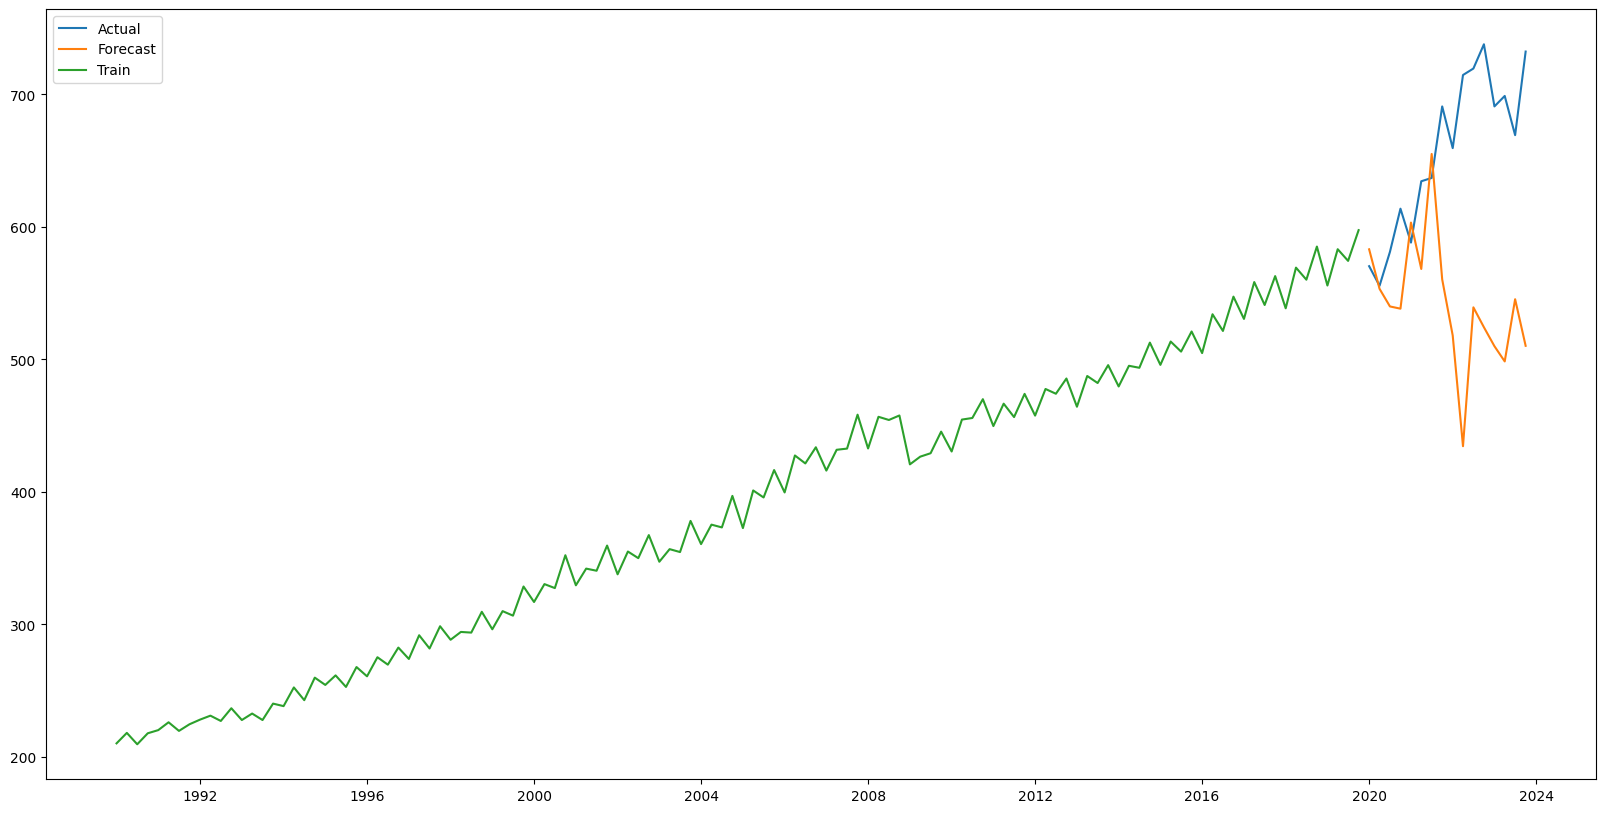

In [23]:
#Converting all relevant columns to numpy arrays
actual = test['gdp'].to_numpy()
forecast = test['gdp_pred'].to_numpy()
test_time = test['Time'].to_numpy()

gdp_train1 = gdp[(gdp['Time'] >= '1990-01-01') & (gdp['Time'] < '2020-01-01')]
historical = gdp_train1['Value'].to_numpy()
historical_time = gdp_train1['Time'].to_numpy()

#Plotting the actual values against the forecasted values
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(test_time, actual, label='Actual')
plt.plot(test_time, forecast, label='Forecast')
plt.plot(historical_time, historical, label='Train')
plt.legend()

plt.show()